<h1>Predicting game prices</h1>
<h5 style="margin-left: 2rem">By: Elad Ben-Haim, Shalev Hadar</h5>
<br/>
<br/>

<h4>נושא המחקר</h4>
<table dir="rtl">
    <tr>
        <th>
            נושא המחקר
        </th>
        <th>
            פירוט הנושא
        </th>
    </tr>
    <tr>
        <td>
        האם ניתן לחזות מחיר של משחק בעוד x זמן?
        </td>
        <td>
        מתי הכי ישתלם לקנות את המשחק בעתיד
        </td>
    </tr>
    <tr>
        <td>
        האם ניתן לחזור מתי למוכר הכי משתלם לעשות מבצע על המשחק?
        </td>
        <td>
        מתי הכי כדאי למוכר לעשות מבצע כדי להביא עוד שחקנים ולהמשיך למכור עם הרווח הגדול ביותר
        </td>
    </tr>
</table>
<br/>

<br/>

<h4>נתוני המחקר ודרכי ניתוח</h4>
<table dir="rtl">
    <tr>
        <th>
            נתוני המחקר & דרכי ניתוח
        </th>
        <th>
             ואיך ננתח אותם
        </th>
    </tr>
    <tr>
        <td>
		פירוט הנתונים: פרטים פיננסיים הוא נמכר בזמן X ואז לחזות בכמה הוא ימכר בזמן Y ובנוסף פרטים על המשחק - כמו שם, ז'אנר פופולריות וכו'.
        </td>
        <td>
            <p style="font-size: 1.1rem">
                נשתמש ב-Crawling על אתר isThereAnyDeal(Fig.3)<br/>
                כדי לא לקבל הודעת שגיאה על שימוש יתר, נשתמש ב-PROXY כדי לא להחסם ע"י isThereAnyDeal<br/>
                ונייבא משם את כל המידע הדרוש כדי לחזות את המחיר של משחק בעוד X זמן מסוים.<br/>
                ראינו שלכל משחק קיים באיזור ה1000+ (Fig.2) רשומות של log (Fig.1) של המחיר שלו ביחס לזמן, ולחנות בה הוא נמכר ואת העלייה\ירידה במחיר של המשחק ביחד ללוג הקודם.<br/>
                בעזרת STEAM API נוציא את ז'אנר המשחק, שנת הייצור ועוד פרטים מורכבים יותר על המשחק עצמו<br/>
                ולבסוף נצרף לכל לוג את פרטי המשחק ונקבל Dataset בגודל n = כמות המשחקים, x = כמות הלוגים, כלומר n*x<br/>
                אנחנו מעוניינים כרגע לקחת את 100 המשחקים הראשונים ולפי מה שראינו כמות הלוגים בדרך כלל היא לפחות 1000 אז נקבל בסביבות ה100,000+ רשומות.<br/>
            </p>
        </td>
    </tr>
    <tr>
        <td>
		דרכי ניתוח: נשתמש בכלים שלמדנו במהלך הקורס לעבד\ללמוד מהנתונים כמה מידע שאנו צריכים למטרה זו
        </td>
        <td>
            <p style="font-size: 1.1rem">
                ננתח את הDataFrame, בעזרת טבלאות יחסי משתנים, סטטיסטיקות, ולבסוף ננסה ללמד מכונה שתחזה את התאריך של המחיר הזול ביותר בשנה מסוימת, ואת המחיר אשר יביא את כמות המכירות הגדול ביותר
            </p>
        </td>
    </tr>
</table>
<br/>
<table style="width:100%;grid-template-rows: 1fr 1fr 1fr;">
<tr>
    <td>
        <figure>
            <img src="images\log_table_for_ds3.png" alt="Is there any deal log table">
            <figcaption>Fig.1 - The main crawled data source</figcaption>
        </figure>
    </td>
    <td>
        <figure>
            <img src="images\number_of_logs_for_ds3.png" alt="Example for number of rows in a typical game">
            <figcaption>Fig.2 - Example for number of rows in a typical game (Dark souls 3) </figcaption>
        </figure>
    </td>
    <td>
        <figure>
            <img src="images\is_there_any_deal_site_example_ds3.png" alt="Is there any deal game page">
            <figcaption>Fig.3 - IsThereAnyDeal game page</figcaption>
        </figure>
    </td>
</tr>

<h4>Importing</h6>

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup
import random
import itertools
import re
import pandas as pd
from pandas import DataFrame
import time
import datetime
import locale
import os.path
import json
import ast
import dateutil.parser
from deep_translator import GoogleTranslator
import pickle


<h4>Global functions</h4>

In [3]:
def get_html_response(url: str, proxy: str = None, params: list = None) -> requests.Response:
    time.sleep(1)
    if (proxy is not None):
        return requests.get(url, proxies={"http": proxy, "https":proxy}, params=params)
    else:
        return requests.get(url, params=params)

def get_response_as_beautiful_soup(req: requests.Response) -> BeautifulSoup:
    return BeautifulSoup(req.text, 'html.parser')

def cache_json(folder_path: str, id: str, get_function):
    if os.path.isfile(f'{folder_path}/{id}.json'):
        f = open(f'{folder_path}/{id}.json', 'r')
        data = json.load(f)
        f.close()
    else:
        data = get_function(id).json()
        f = open(f'{folder_path}/{id}.json', 'a')
        f.write(json.dumps(data))
        f.close()
    return data

def cache_soup(folder_path: str, id: str, get_function):
    if os.path.isfile(f'{folder_path}/{id}.html'):
        f = open(f'{folder_path}/{id}.html', 'r')
        soup = BeautifulSoup(f.read(), 'html.parser')
        f.close()
    else:
        res = get_function(id)
        f = open(f'{folder_path}/{id}.html', 'a')
        f.write(res.text)
        f.close()
        soup = get_response_as_beautiful_soup(res)
    return soup

def translate(source: str):
    url = 'translations.pickle'
    translations = dict()
    if os.path.isfile(url):
        f = open(url, "rb")
        translations = pickle.load(f)
        f.close()
    
    translation = translations.get(source)
    if translation is not None:
        return translation

    translator = GoogleTranslator(source='auto', target='en')
    translation = translator.translate(source)
    translations[source] = translation
    f = open( url, "wb" )
    pickle.dump(translations, f)
    f.close()
    return translation

def get_len(col):
    if type(col) is list:
        return len(col)
    else:
        return 0

def pluck(key):
    return lambda col: col.get(key) if type(col) is dict else None

def pluckBy(key, okFunction = lambda val: val, errFunction = lambda _: None):
    return lambda col: okFunction(col.get(key)) if type(col) is dict else errFunction(None)

def parse_datetime(datetime_str: str):
    try:
        return dateutil.parser.parse(datetime_str)
    except:
        return dateutil.parser.parse(translate(datetime_str))
        

<br/>

<h4>Defining proxies for scraping</h4>

<h5>Get proxy list response html website</h5>
<h6>get the html as response object instead of getting the html again and again</h6>

In [4]:
# Get the html of the proxy list website
def get_proxy_list_html() -> requests.Response:
    # Website to get free proxies
    return get_html_response('https://free-proxy-list.net/')

In [5]:
proxies_response = get_proxy_list_html()

<h5>Scrape proxy ip addresses</h5>
<h6>gets the ip addresses as a list, shuffles them and returns an iterator to cycle through when making scrape requests</h6>

In [6]:
def get_proxy_list() -> itertools.cycle:
    soup = get_response_as_beautiful_soup(proxies_response)
    proxy_soup_list = soup.select('#list > div > div.table-responsive > div > table > tbody > tr')
    proxy_list = list(map(lambda i: i.select('td:nth-child(1)')[0].text + ':' + i.select('td:nth-child(2)')[0].text, proxy_soup_list))
    length = len(proxy_list)
    random.shuffle(proxy_list)
    return itertools.cycle(proxy_list), length

In [7]:
proxy_list, proxy_list_length = get_proxy_list()
current_proxy = next(proxy_list)

In [8]:
def get_proxied(url: str, params: list = None) -> requests.Response:
    i = 0
    while(i < proxy_list_length / 2):
        try:
            response = get_html_response(url, current_proxy, params=params)
            time.sleep(2)
            return response
        except:
            i += 1
        finally:
            current_proxy = next(proxy_list)

    raise RuntimeError('Half of the proxies provided don`t work.')

<br/>

<h2>Crawling + Analyzing</h2>

<h4>Scrape isThereAnyDeal website</h4>
<h6>Steps:</h6>
<ol>
<li>Crawl list of top 100 trending games</li>
<li>For each game:</li>
<ul>
    <li>get the game details from steam API using "appId" scraped either from PC Gaming Wiki or Steam Ladder links</li>
    <li>mine price Log history on isThereAnyDeal</li>
    <li>mine Number of sales of the game</li>
<ul>
</ol>

In [9]:
is_there_any_deal_url = 'https://isthereanydeal.com'
steam_api_url = 'https://store.steampowered.com/api/appdetails'

<h5>Get list of 100 top trending games</h5>

In [10]:
def get_is_there_any_deal_games_response() -> requests.Response:
    filteredUrl = 'https://isthereanydeal.com/'
    return get_html_response(filteredUrl)

In [11]:
is_there_any_deal_games_response = get_is_there_any_deal_games_response()
print(is_there_any_deal_games_response)

<Response [200]>


In [12]:
def add_game_to_dataframe(df: DataFrame, game: dict) -> DataFrame:
    return df.append(DataFrame([game]), ignore_index=True)

In [13]:
def get_steam_api_game_response(steamId: str) -> requests.Response:
    return get_html_response(steam_api_url, params={'appids': steamId})

In [14]:
def delete_if_exists(d: dict, *keys: list) -> dict:
    for key in keys:
        if d.get(key) is not None:
            del d[key]
    return d

In [15]:
def get_steam_api_game_details(steamId: str) -> dict:
    data = cache_json('steam_api_details', steamId, get_steam_api_game_response)
    if data.get(steamId) is None or data.get(steamId).get('data') is None:
        return {}
    data = data[steamId]['data']

    if data.get('categories') is not None: # GAME ,,,,, [{id:3, name: ACTION}, {id:5, name:ROUGE_LIKE}]
        for category in data['categories']:
            data['category.'+str(category['id'])]=True
        del data['categories']
    
    if data.get('genres') is not None:
        for genre in data['genres']:
            data['genre.'+str(genre['id'])]=True
        del data['genres']
    
    if data.get('developers') is not None:
        for developer in data['developers']:
            data[f'developer.' + developer.strip().replace(' ', '_')]=True
        del data['developers']
    
    if data.get('publishers') is not None:
        for publisher in data['publishers']:
            data[f'publisher.' + publisher.strip().replace(' ', '_')]=True
        del data['publishers']
        
    if data.get('supported_languages') is not None: # <strong>*</strong>English<strong>*</strong>, Japanese, Spanish => ['English', 'Japanese', 'Spanish']
        for language in data['supported_languages']\
                            .replace('<strong>*</strong>', '')\
                            .replace('<br/>', '')\
                            .replace('<br>', '')\
                            .replace('languages with full audio support', '')\
                            .split(','):
            data[f'supported_language.' + language.strip().replace(' ', '_')]=True
        del data['supported_languages']

    return data

<img style="width: 50%" src="images/steam_api_response.png"/>

In [16]:
def get_game_dataframe():
    soup = get_response_as_beautiful_soup(is_there_any_deal_games_response)
    df = DataFrame()
    games = soup.select("#games > div.game")
    game_dict = dict()
    for game in games:
        steamId = game.attrs.get('data-steamid')
        if steamId is not None:
            steamId: str
            if 'app' in steamId:
                steamId = steamId.split('/')[1] # app/{steamId}
                title = game.select("div.title > a")[0].text
                history = game.select("div.overview.exp.tgl-hide > a:nth-child(5)")[0].attrs.get('href')
                game_details = get_steam_api_game_details(steamId)
                if game_details == {}: continue
                df = add_game_to_dataframe(df, {'steamId': steamId, 'title': title, 'history_link': is_there_any_deal_url + history, **game_details})
    return df

In [17]:
games_dataframe = get_game_dataframe()
games_dataframe.to_csv('games_dataframe.csv')
games_dataframe

,steamId,title,history_link,type,name,steam_appid,required_age,is_free,controller_support,detailed_description,...,developer.Motion_Twin,publisher.Motion_Twin,developer.Paradox_Development_Studio,publisher.Paradox_Interactive,developer.Square_Enix,developer.Toylogic_Inc.,developer.Larian_Studios,publisher.Larian_Studios,developer.Redbeet_Interactive,publisher.Axolot_Games
0,1285040,D-Corp,https://isthereanydeal.com/game/dcorp/history/,game,D-Corp,1285040,0,False,full,<h1>Join the Discord community!</h1><p><a href...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1174180,Red Dead Redemption 2,https://isthereanydeal.com/game/reddeadredempt...,game,Red Dead Redemption 2,1174180,17,False,NaN,"<h1>Ultimate Edition</h1><p><img src=""https://...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1151640,Horizon Zero Dawn™ Complete Edition,https://isthereanydeal.com/game/horizonzerodaw...,game,Horizon Zero Dawn™ Complete Edition,1151640,16,False,full,EARTH IS OURS NO MORE<br />\r\n<br />\r\nExper...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1091500,Cyberpunk 2077,https://isthereanydeal.com/game/cyberpunkii0vi...,game,Cyberpunk 2077,1091500,18,False,NaN,<h1>Check out other games from CD PROJEKT RED<...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,870780,Control,https://isthereanydeal.com/game/control/history/,game,Control Ultimate Edition,870780,16,False,full,"<img src=""https://cdn.akamai.steamstatic.com/s...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,588650,Dead Cells,https://isthereanydeal.com/game/deadcells/hist...,game,Dead Cells,588650,0,False,full,"<h1>New DLC Available</h1><p><h2 class=""bb_tag...",...,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,281990,Stellaris,https://isthereanydeal.com/game/stellaris/hist...,game,Stellaris,281990,0,False,NaN,"<h1>Just Updated</h1><p><a href=""https://store...",...,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN
76,1113560,NieR Replicant™ ver.1.22474487139...,https://isthereanydeal.com/game/nierreplicantv...,game,NieR Replicant™ ver.1.22474487139...,1113560,18,False,NaN,"<h1>Reviews &amp; Accolades</h1><p><img src=""h...",...,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN
77,435150,Divinity: Original Sin 2 - Definitive Edition,https://isthereanydeal.com/game/divinityorigin...,game,Divinity: Original Sin 2 - Definitive Edition,435150,0,False,full,<h1>Digital Collector's Editions</h1><p><img s...,...,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN


In [18]:
games_dataframe = pd.read_csv('./games_dataframe.csv')

In [19]:
def drop_columns(df: DataFrame, columns) -> DataFrame:
    return df.drop(columns, axis=1)

def use_val(fun):
    return lambda col: fun(ast.literal_eval(col)) if type(col) is str else fun(col)


In [20]:

def map_steam_api_game_data(ndf: DataFrame) -> DataFrame:
    df = ndf.copy()
    ignored_columns = [
        'type',
        'name',
        'steam_appid',
        'detailed_description',
        'about_the_game',
        'short_description',
        # 'fullgame',
        'header_image',
        'website',
        'pc_requirements',
        'mac_requirements',
        'linux_requirements',
        'legal_notice',
        'price_overview',
        'package_groups',
        'screenshots',
        'achievements',
        'background',
        'content_descriptors',
        'support_info',
        'ext_user_account_notice',
        'reviews',
        'drm_notice'
    ]
    df = drop_columns(df, ignored_columns)

    for (new_col, col) in (('number_of_demos', 'demos'), ('num_of_game_videos', 'movies'), ('num_of_dlc', 'dlc'), ('num_of_packages_game_is_in', 'packages')):
        df[new_col] = df[col].apply(use_val(get_len))
        df = drop_columns(df, col)

    df['metacritic_score'] = df['metacritic'].apply(use_val(pluckBy('score', lambda score: score / 100)))
    df = drop_columns(df, 'metacritic')

    for (new_col, col, key) in (('windows_supported', 'platforms', 'windows'), ('mac_supported', 'platforms', 'mac'), ('linux_supported', 'platforms', 'linux')):
        df[new_col] = df[col].apply(use_val(pluckBy(key, lambda val: val == True, lambda _: False)))
    df = drop_columns(df, 'platforms')
    
    df['total_steam_recommendations'] = df['recommendations'].apply(use_val(pluck('total')))
    df = drop_columns(df, 'recommendations')

    df['release_date'] = df['release_date'].apply(use_val(pluckBy('date', parse_datetime)))

    for col in filter(lambda c: len(c.split('.')) > 1,df.columns):
        df[col].fillna(False, inplace=True)
    return df

In [21]:
games_dataframe2 = map_steam_api_game_data(games_dataframe)
games_dataframe2.to_csv('games_details_data.csv')

<h5>Get price history for each game</h5>

In [40]:
pounds_to_usd_conversion_rate = 1.34

In [59]:
def convert_to_usd(price: str) -> float:
    parsed_price = float(re.sub('\$|\£|\s','',price).strip().lstrip())
    
    if ('£' in price):
        parsed_price = parsed_price * pounds_to_usd_conversion_rate

    return parsed_price

In [64]:
def get_game_history_details(steamId: str, history_link: str) -> DataFrame:
    soup = cache_soup('games', steamId, lambda x: get_html_response(history_link))
    
    df = DataFrame()
    vals = soup.select("div.lg2.game")
    for val in vals:
        dateText = val.select_one("span.lg2__time-rel").attrs['title']
        date = datetime.datetime.strptime(dateText, '%a, %d %b %Y %H:%M:%S +0000')
        shop_title = val.select_one('.shopTitle').text.strip()
        regular_price_text = val.select_one('div:nth-child(2) > span.lg2__price').text
        price_now_text = val.select_one('div:nth-child(3) > span.lg2__price').text
        regular_price = convert_to_usd(regular_price_text)
        price_now = convert_to_usd(price_now_text)

        if (regular_price != 0):
            price_change_percentage = price_now / regular_price
        else:
            price_change_percentage = 0
        df = df.append(DataFrame([{'record_date': date, 'shop': shop_title, 'regular_price': regular_price, 'price_now': price_now, 'price_change': price_change_percentage}]))
    return df


In [102]:
def get_games_with_history():
    games_with_history = DataFrame()
    for index, row in games_dataframe2.iterrows():
        row_df = DataFrame([row])
        game_history_details = get_game_history_details(row['steamId'], row['history_link'])

        game_history_details['key'] = 1
        row_df['key'] = 1

        cross = row_df.merge(game_history_details, how = 'outer')
        games_with_history = games_with_history.append(cross)
    
    games_with_history.dropna(subset=['shop', 'regular_price'], inplace=True)
    return games_with_history

In [ ]:
games_with_history = get_games_with_history()

In [120]:
def clean_game_history_details(ndf: DataFrame) -> DataFrame:
    df = ndf.copy()
    if (df.get('shop') is not None):
        df.drop(df[df['shop']=='voidu'].index, inplace=True)
        df.drop(df[df['shop']=='Voidu'].index, inplace=True)
    if (df.get('regular_price') is not None):
        df.drop(df[df['regular_price'] == 0].index, inplace=True)

    df['controller_support'].fillna('no', inplace=True)
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
    df.drop(['key'], axis=1, inplace=True)
    return df

In [118]:
cleaned_games_with_history = clean_game_history_details(games_with_history)

In [119]:
cleaned_games_with_history.to_csv('games_with_history.csv')

<h2>Exploratory Data Analysis</h2>

<h5>Functions</h5>

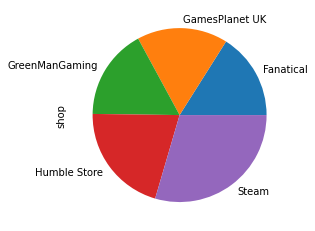

In [124]:
def get_frequent_elements(df: DataFrame, col_name: str, num_top_elements: int):
    return pd.Series(df[col_name].value_counts()[:num_top_elements].sort_index())

def one_dim_plot(sr: pd.Series, plot_type: str, axis: int = None):
    return sr.plot(kind=plot_type, ax=axis)

def plot_frequency(df: DataFrame, col: str):
    elm = get_frequent_elements(df, col, 5)
    one_dim_plot(elm, 'pie')

def plot_shop(df: DataFrame):
    plot_df = df.copy()
    plot_df.drop_duplicates(subset=['shop', 'steamId'], inplace=True)
    plot_frequency(plot_df, 'shop')

plot_shop(cleaned_games_with_history)

<h3>Used Resources</h3>
<dl>
    <dt>Scraping</dt>
    <dd>
        <a href="https://isthereanydeal.com/game/reddeadredemptionii/info/">
            <b>Is-There-Any-Deal website</b> For scraping cost history and more financial details
        </a>
    </dd>
    <dd>
        <a href="https://www.geeksforgeeks.org/web-scraping-without-getting-blocked/">
            <b>Using Proxies to avoiding getting blocked</b>
        </a>
    </dd>
    <dd>
        <a href="https://wiki.teamfortress.com/wiki/User:RJackson/StorefrontAPI#App_info">
            <b>Steam StoreFront API</b> Limited to 100,000 requests per day, and no more than 10 per second
        </a>
    </dd>
    <dd>
        <a href="https://store.steampowered.com/api/appdetails">Steam API for Game Metadata - https://store.steampowered.com/api/appdetails?appids=1091500</a>
    </dd>
    <dd><a href="https://www.programiz.com/python-programming/json">Using json serialization and parsing</a></dd>
</dl>